# Data preparation from Chapter 02

In [223]:
import sys
from packaging import version

# Download the Data
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt

# Create a Test Set
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import binom
from sklearn.model_selection import StratifiedShuffleSplit

# Looking for Correlations
from pandas.plotting import scatter_matrix

# Data Cleaning
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

# Handling Text and Categorical Attributes
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

# Custom Transformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans

# Transformation Pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

# Training and Evaluating on the Training Set
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# Better Evaluation Using Cross-Validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Fine-Tune Your Model
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import randint, uniform, geom, expon
from scipy.stats import loguniform

# Evaluate Your System on the Test Set
from scipy import stats

# Model persistence using joblib
import joblib

########
from sklearn.svm import SVR

In [136]:
set_config(display='diagram')

In [138]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [140]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [142]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [144]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [146]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [148]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

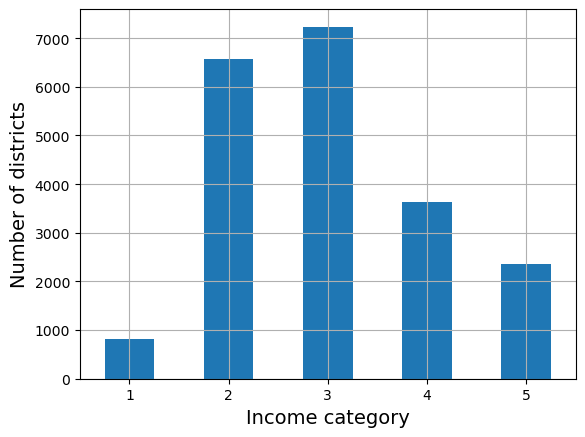

In [150]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [152]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [154]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [156]:
housing = strat_train_set.copy()

In [158]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [160]:
housing_num = housing.select_dtypes(include=[np.number])

In [162]:
housing_cat = housing[["ocean_proximity"]]

In [164]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())


log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [166]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [168]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [170]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

In [172]:
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C423E5B3D0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C42481E0A0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [174]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.01, 0.  , 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [182]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41385.520595938855


# Exercises

## 1.

In [247]:
full_pipeline_E1 = Pipeline([
    ("preprocessing", preprocessing),
    ("SVR", SVR()),
])
param_grid_E1 = [
    {'SVR__kernel': ['rbf'],
     'SVR__C': [0.1, 0.7, 1.0, 1.2],
     'SVR__gamma': [0.01, 0.07, 0.10, 0.12]},
    {'SVR__kernel': ['linear'],
     'SVR__C': [0.1, 0.5, 0.7, 1.0, 1.2, 1.4, 1.6]},
]
grid_search_E1 = GridSearchCV(full_pipeline_E1, param_grid_E1, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search_E1.fit(housing.iloc[:5000 , :], housing_labels[:5000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001C424844460>)])),
                                       ('SVR', SVR())]),
             param_grid=[{'SVR__C': [0.1, 0.7, 1.0, 1.2],
                          'SVR__gamma': [0.01, 0.07, 0.1, 0.12],
                          'SVR__kernel': ['rbf']},
                         {'SVR__C': [0.1, 0.5, 0.7, 1.0, 1.2, 1.4, 1.6],
                          'SVR__kernel': ['linear']}],
             scoring='neg_root_mean_squared_error')

In [249]:
grid_search_E1.best_params_

{'SVR__C': 1.6, 'SVR__kernel': 'linear'}

In [251]:
grid_search_E1.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000001C...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C427DDFC40>)])),
                ('SVR', SVR(C=1.6, kernel='linear'))])

In [253]:
grid_search_E1.cv_results_

{'mean_fit_time': array([1.64711889, 1.64339153, 1.63442834, 1.62598093, 1.63946939,
        1.63503591, 1.62903921, 1.61837363, 1.63425159, 1.63092844,
        1.62288237, 1.62419788, 1.61969972, 1.63114746, 1.61811352,
        1.62304354, 1.54676461, 1.55635492, 1.54309972, 1.54190667,
        1.54434991, 1.54634953, 1.53159618]),
 'std_fit_time': array([0.01204101, 0.010628  , 0.00164472, 0.0102881 , 0.00451948,
        0.00543596, 0.00531712, 0.00584062, 0.01044935, 0.01116282,
        0.00185512, 0.00354889, 0.01268397, 0.00628265, 0.00240878,
        0.0034001 , 0.0098383 , 0.00860725, 0.00276892, 0.00480184,
        0.00566959, 0.00637698, 0.01056089]),
 'mean_score_time': array([1.14325833, 1.14933538, 1.13993088, 1.13868229, 1.14459181,
        1.133593  , 1.12493149, 1.13291677, 1.14017367, 1.13765494,
        1.13391908, 1.14309112, 1.14191628, 1.13219102, 1.13589207,
        1.14897688, 0.72824089, 0.72249667, 0.71652325, 0.72148903,
        0.72951388, 0.71916   , 0.710593

In [255]:
cv_res_E1 = pd.DataFrame(grid_search_E1.cv_results_)
cv_res_E1.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res_E1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_SVR__C,param_SVR__gamma,param_SVR__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
22,1.531596,0.010561,0.710593,0.001140,1.6,NaN,linear,"{'SVR__C': 1.6, 'SVR__kernel': 'linear'}",-117466.028946,-119543.215587,-113419.944323,-116809.729619,2542.526217,1
21,1.546350,0.006377,0.719160,0.005353,1.4,NaN,linear,"{'SVR__C': 1.4, 'SVR__kernel': 'linear'}",-117847.412572,-119892.027823,-113790.422394,-117176.620930,2535.727151,2
20,1.544350,0.005670,0.729514,0.006132,1.2,NaN,linear,"{'SVR__C': 1.2, 'SVR__kernel': 'linear'}",-118136.348433,-120229.064415,-114131.187738,-117498.866862,2529.929124,3
19,1.541907,0.004802,0.721489,0.010066,1.0,NaN,linear,"{'SVR__C': 1.0, 'SVR__kernel': 'linear'}",-118478.959503,-120576.800665,-114504.103147,-117853.287772,2518.334452,4
18,1.543100,0.002769,0.716523,0.002600,0.7,NaN,linear,"{'SVR__C': 0.7, 'SVR__kernel': 'linear'}",-119074.889244,-121152.722380,-114973.901184,-118400.504269,2567.171486,5
17,1.556355,0.008607,0.722497,0.006348,0.5,NaN,linear,"{'SVR__C': 0.5, 'SVR__kernel': 'linear'}",-119467.881614,-121606.303807,-115349.356239,-118807.847220,2596.675088,6
16,1.546765,0.009838,0.728241,0.003184,0.1,NaN,linear,"{'SVR__C': 0.1, 'SVR__kernel': 'linear'}",-120209.221598,-122451.873977,-116095.718964,-119585.604846,2632.090427,7
13,1.631147,0.006283,1.132191,0.011057,1.2,0.07,rbf,"{'SVR__C': 1.2, 'SVR__gamma': 0.07, 'SVR__kern...",-120318.909800,-122554.236229,-116180.731140,-119684.625723,2640.344548,8
14,1.618114,0.002409,1.135892,0.004705,1.2,0.10,rbf,"{'SVR__C': 1.2, 'SVR__gamma': 0.1, 'SVR__kerne...",-120321.514366,-122553.988959,-116180.671036,-119685.391454,2640.490435,9
15,1.623044,0.003400,1.148977,0.012752,1.2,0.12,rbf,"{'SVR__C': 1.2, 'SVR__gamma': 0.12, 'SVR__kern...",-120327.636227,-122558.043117,-116184.648667,-119690.109337,2640.690516,10


## 2.

## 3.

## 4.

## 5.